In [13]:
import base64
from datetime import datetime, timedelta
import json
import os
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import seaborn as sns
from shapely.geometry import box, Point, Polygon

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from library import utils
from FH_Hydrosat import FH_Hydrosat

In [14]:
# Insitu point locations
insitu_met_points = {
    'Corn': [-121.5351, 38.1091],
    'Alfalfa': [-121.4993, 38.0992]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

aoi_bbox = {
    'Alfalfa': [-121.5365, 38.1098, -121.5355, 38.1091],
    'Corn': [-121.5027, 38.0986, -121.5003, 38.1000]
}

In [15]:
# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')
bi1_data_path = os.path.join(data_path, 
                             'US-Bi1_HH_201608130000_202301010000.csv')

In [16]:
# Explore bi1 data
bi1_df = utils.read_ameriflux(bi1_data_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')

Data range from 2016-08-13 00:00:00 to 2022-12-31 23:30:00


In [20]:
bi1_df.columns

Index(['end', 'TIMESTAMP_START', 'TIMESTAMP_END', 'CO2', 'H2O', 'CH4', 'FC',
       'FCH4', 'FC_SSITC_TEST', 'FCH4_SSITC_TEST', 'G', 'H', 'LE',
       'H_SSITC_TEST', 'LE_SSITC_TEST', 'WD', 'WS', 'USTAR', 'ZL', 'TAU',
       'MO_LENGTH', 'V_SIGMA', 'W_SIGMA', 'TAU_SSITC_TEST_F', 'PA', 'RH', 'TA',
       'VPD', 'T_SONIC', 'T_SONIC_SIGMA', 'TS_1_1_1', 'TS_1_2_1', 'TS_1_3_1',
       'TS_1_4_1', 'TS_1_5_1', 'TS_2_1_1', 'TS_2_2_1', 'TS_2_3_1', 'TS_2_4_1',
       'TS_2_5_1', 'TS_3_1_1', 'TS_3_2_1', 'TS_3_3_1', 'TS_3_4_1', 'TS_3_5_1',
       'SWC_1', 'SWC_2', 'NETRAD', 'PPFD_IN', 'PPFD_OUT', 'SW_IN', 'SW_OUT',
       'LW_IN', 'LW_OUT', 'P', 'FC_F', 'RECO_F', 'GPP_F', 'FCH4_F', 'H_F',
       'LE_F', 'SPEC_RED_IN', 'SPEC_RED_OUT', 'SPEC_NIR_IN', 'SPEC_NIR_OUT',
       'NDVI', 'SPEC_PRI_TGT_IN', 'SPEC_PRI_TGT_OUT', 'SPEC_PRI_REF_IN',
       'SPEC_PRI_REF_OUT', 'PRI'],
      dtype='object')

<Axes: xlabel='start', ylabel='NDVI'>

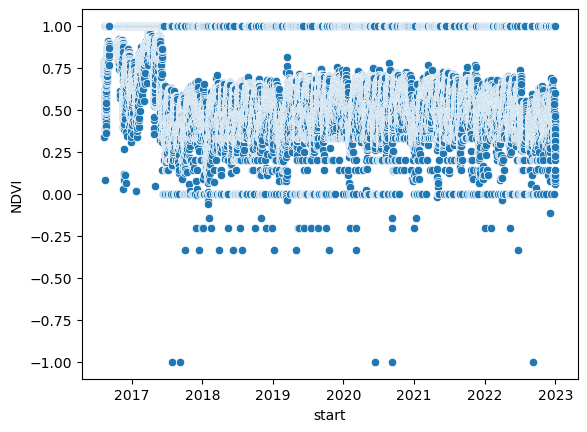

In [21]:
sns.scatterplot(bi1_df['NDVI'])

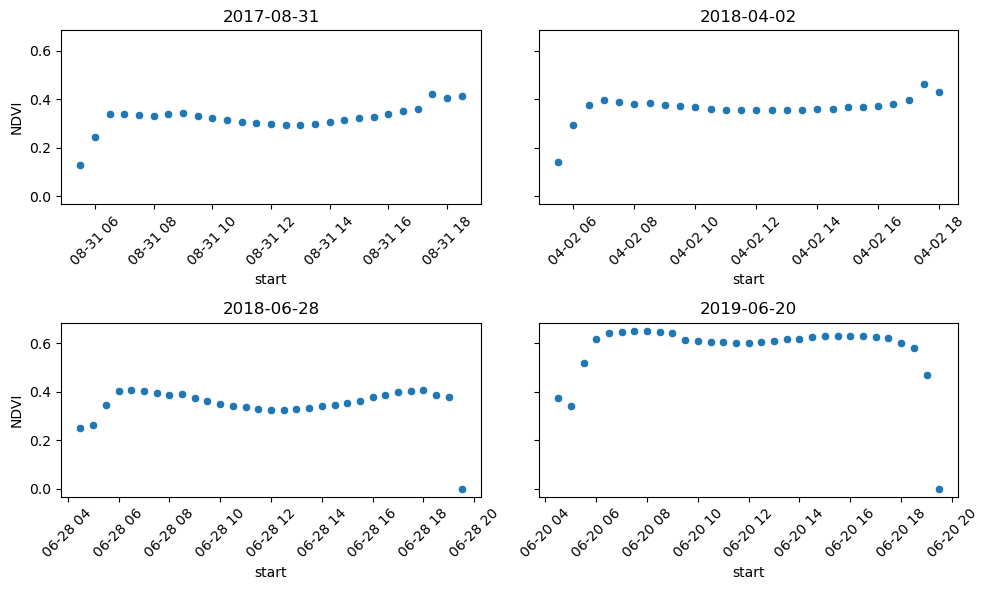

In [22]:
dates = ['2017-08-31', '2018-04-02', '2018-06-28', '2019-06-20']
fig, axes = plt.subplots(2,2, figsize=(10,6), sharey=True)
for date, ax in zip(dates, axes.flatten()):
    date_start = pd.to_datetime(date)
    date_end = date_start + timedelta(hours=24)
    filt = (bi1_df.index > date_start) &  (bi1_df.index < date_end)
    sns.scatterplot(bi1_df.loc[filt, 'NDVI'], ax=ax).set(title=date)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout();

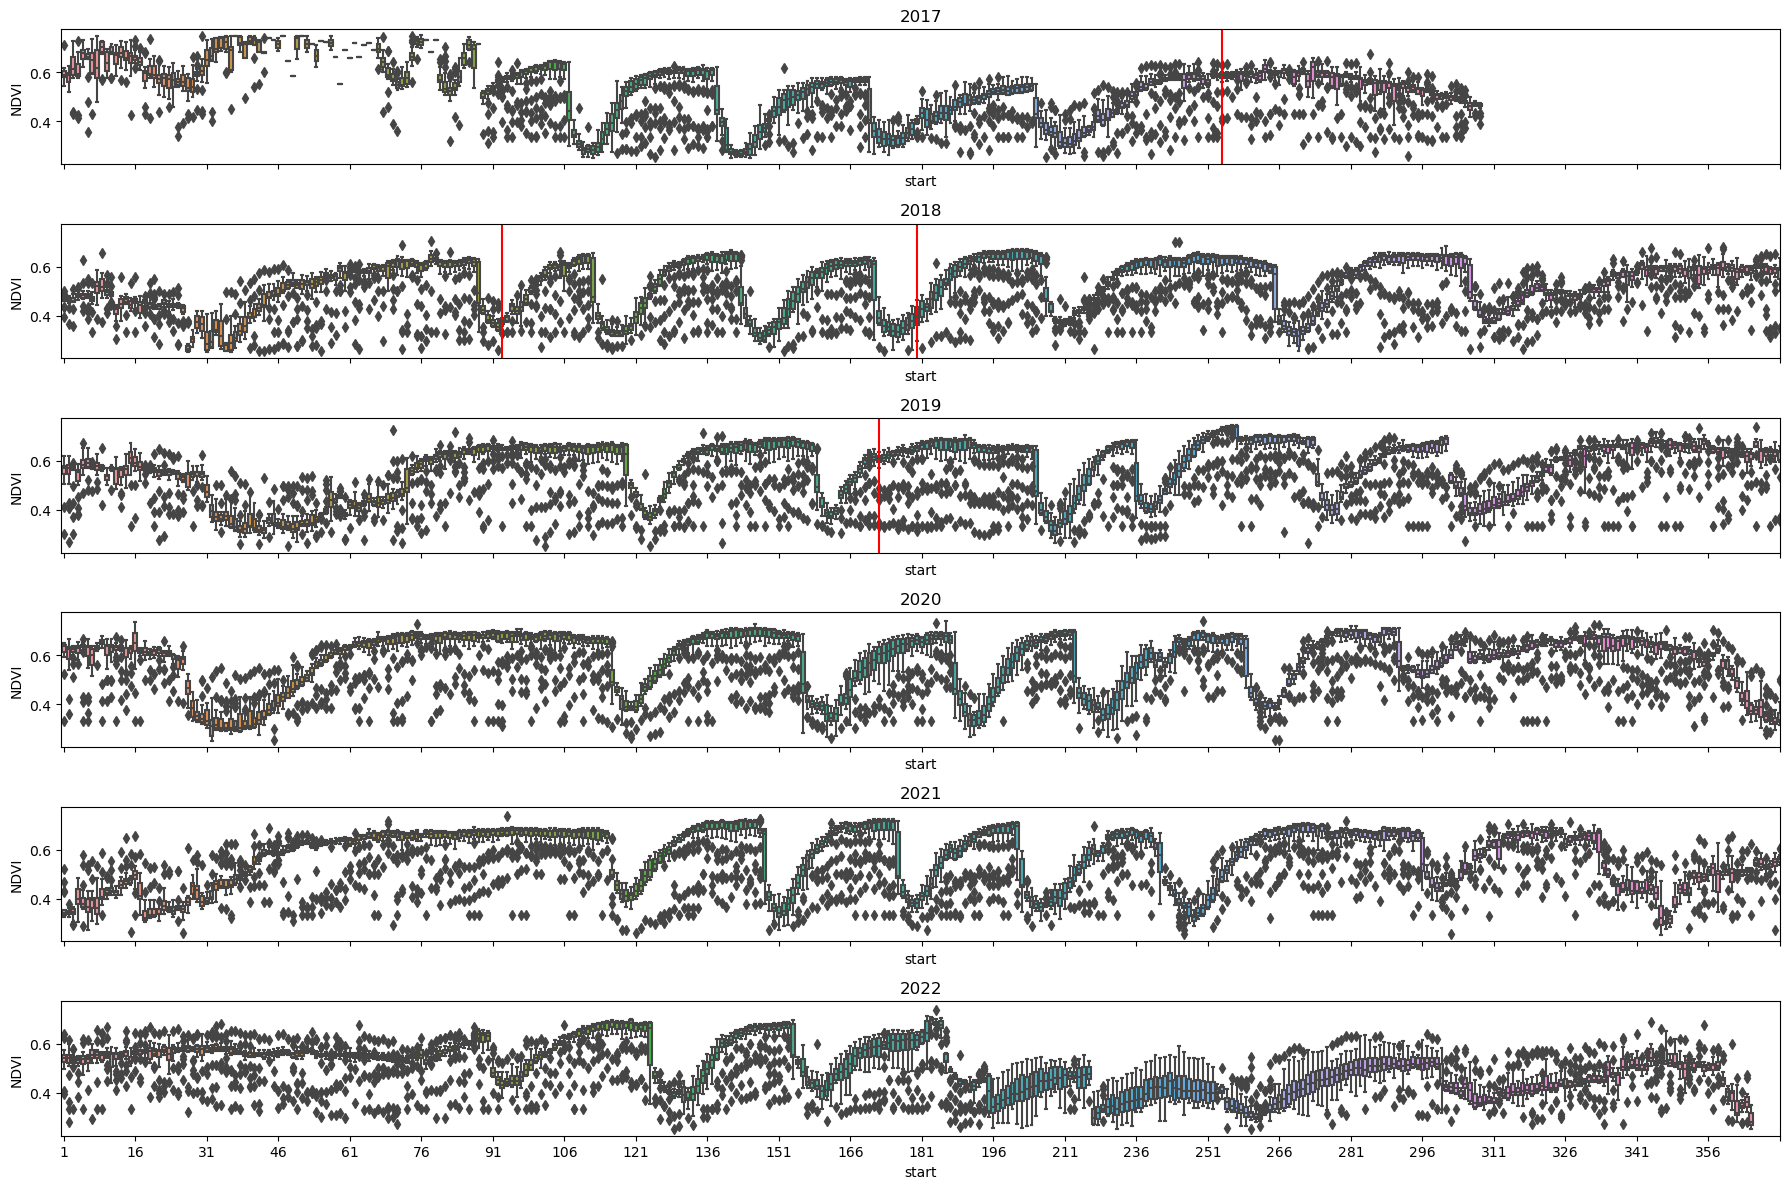

In [23]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
years = [2017, 2018, 2019, 2020, 2021, 2022]

fig, axes = plt.subplots(6, 1, figsize=(18, 12), sharex=True, sharey=True)
for year, ax in zip(years, axes.flatten()):
    df = bi1_df.loc[filt]
    df_year = df.loc[df.index.year == year]
    sns.boxplot(x=df_year.index.dayofyear,
                y=df_year['NDVI'],
                ax=ax).set(title=year)
    
    # df.loc[filt2].groupby(df_year.index.dayofyear)['NDVI'].mean().plot(ax=ax, color='k')
    plt.xticks(range(0,365,15))

axes.flatten()[0].axvline(x=pd.to_datetime(dates[0]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[1].axvline(x=pd.to_datetime(dates[1]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[1].axvline(x=pd.to_datetime(dates[2]).dayofyear, ymin=0, ymax=1, color='r')
axes.flatten()[2].axvline(x=pd.to_datetime(dates[3]).dayofyear, ymin=0, ymax=1, color='r')
plt.tight_layout();

In [24]:
# Authenticate and access catalog
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [17]:
geom = {'type': 'Point', 'coordinates': crop_center_points['Alfalfa']}
start_date = "2021-01-01T00:00:00Z"
end_date = "2022-12-31T00:00:00Z"
pt = Point(geom['coordinates'])
collections_dict = {
    'collection': ['prepped_inputs_s2', 
                   'prepped_inputs_landsat', 
                   'prepped_inputs_mcd43a4', 
                   'prepped_inputs_mod21a1d',
                   'pydms_sharpened_modis',
                   'pydms_sharpened_landsat',
                   'starfm_predictions_modis_landsat'],
    'asset': ['surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'lst',
              'lst',
              'lst'],
    'tolerance': [40, 60, 1000, 2000, 1000, 40, 40],
    'red_band': [2, 2, 0, 0, 0,  0,  0],
    'nir_band': [6, 6, 1,  1,  0,  0, 0]
}
collections_df = pd.DataFrame(collections_dict)
collections_df

,collection,asset,tolerance,red_band,nir_band
0,prepped_inputs_s2,surface_reflectance,40,2,6
1,prepped_inputs_landsat,surface_reflectance,60,2,6
2,prepped_inputs_mcd43a4,surface_reflectance,1000,0,1
3,prepped_inputs_mod21a1d,surface_reflectance,2000,0,1
4,pydms_sharpened_modis,lst,1000,0,0
5,pydms_sharpened_landsat,lst,40,0,0
6,starfm_predictions_modis_landsat,lst,40,0,0


In [74]:
def ndvi_from_collection(col_index, collections_df):
    search = catalog.search(
        collections=collections_df.iloc[col_index]['collection'],
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )

    s2_items = search.get_all_items()
    print(f'number of source {collections_df.iloc[col_index]["collection"]} items: {len(s2_items)}')

    assets = s2_items[0].to_dict()['assets'].keys()
    if len(s2_items) > 0 and 'surface_reflectance' in assets:
        res_full = FH_Hydrosat(s2_items, asset='surface_reflectance')
        res_dt = res_full.datetime
        tolerance = collections_df.iloc[col_index]['tolerance']
        red_band = collections_df.iloc[col_index]['red_band']
        nir_band = collections_df.iloc[col_index]['nir_band']

        red_ts = res_full.point_time_series_from_items(pt, tol=tolerance, nproc=6, band=red_band)
        nir_ts = res_full.point_time_series_from_items(pt, tol=tolerance, nproc=6, band=nir_band)

        ndvi_ts = (np.array(nir_ts) - np.array(red_ts)) / (np.array(nir_ts) + np.array(red_ts))
        ndvi_dt = res_dt

        ndvi_df = pd.DataFrame({'ndvi': ndvi_ts,
                                'datetime': pd.to_datetime(ndvi_dt)}).sort_values(by='datetime')
        ndvi_df.index = pd.to_datetime(ndvi_df['datetime'].dt.strftime('%Y-%m-%d'))

        ndvi_series = ndvi_df['ndvi'].astype('float')
        ndvi_series.name = collections_df.iloc[col_index]['collection']

        return ndvi_series

In [75]:
ndvi_results = []
for i in [0, 2]:  # TODO: allow for calculation of ndvi for all assets
    ndvi_series = ndvi_from_collection(i, collections_df)
    ndvi_series = ndvi_series[~ndvi_series.index.duplicated(keep='first')]
    ndvi_results.append(ndvi_series)
ndvi_df = pd.concat(ndvi_results, axis=1)

number of source prepped_inputs_s2 items: 111
using 6 processes to sample 111 assets
using 6 processes to sample 111 assets
number of source prepped_inputs_mcd43a4 items: 736
using 6 processes to sample 736 assets
using 6 processes to sample 736 assets


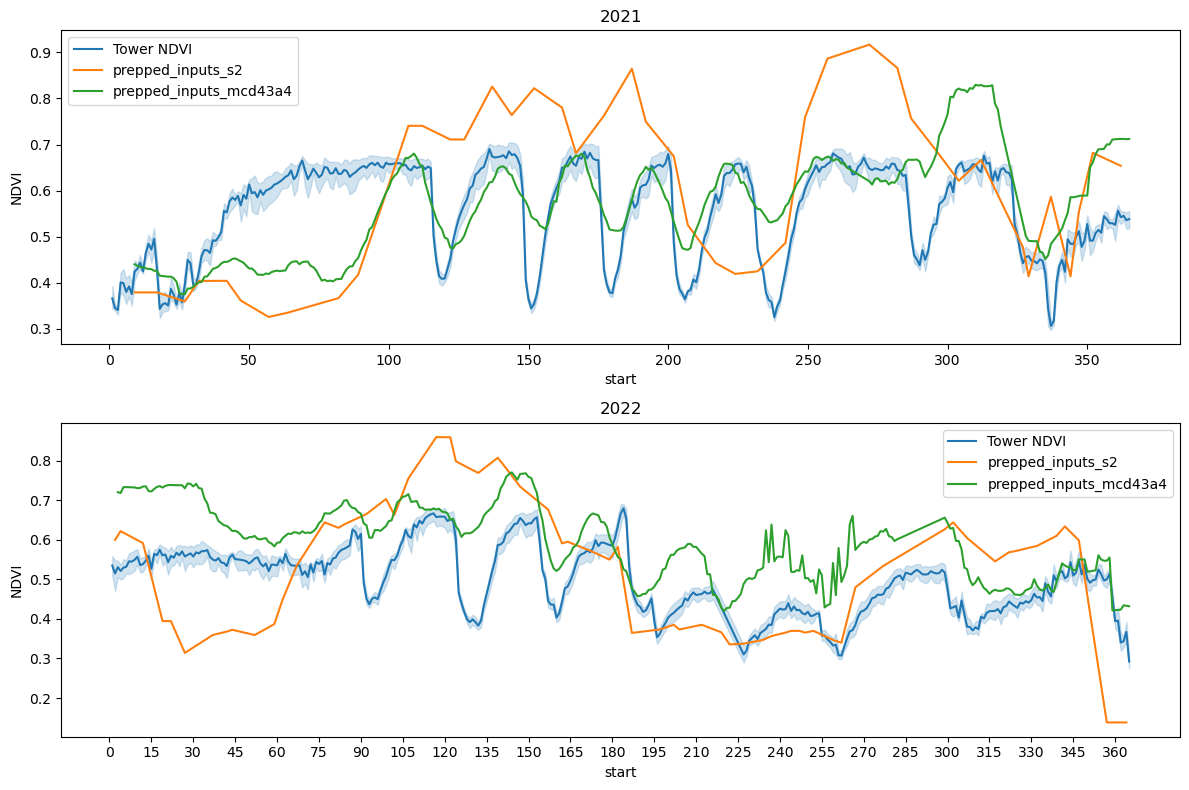

In [76]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
year = 2021

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
df = bi1_df.loc[filt]
df_year = df.loc[df.index.year == year]
# sns.boxplot(x=df_year.index.dayofyear,
#             y=df_year['NDVI'],
#             ax=ax).set(title=year)
sns.lineplot(x=df_year.index.dayofyear,
            y=df_year['NDVI'],
            ax=axes[0], label='Tower NDVI').set(title=year)

ndvi_df_year = ndvi_df.loc[ndvi_df.index.year == year]
for col in ndvi_df_year.columns:
    sns.lineplot(x=ndvi_df_year.index.dayofyear,
            y=ndvi_df_year[col],
            ax=axes[0], label=col)
    
year = 2022
df_year = df.loc[df.index.year == year]
# sns.boxplot(x=df_year.index.dayofyear,
#             y=df_year['NDVI'],
#             ax=ax).set(title=year)
sns.lineplot(x=df_year.index.dayofyear,
            y=df_year['NDVI'],
            ax=axes[1], label='Tower NDVI').set(title=year)

ndvi_df_year = ndvi_df.loc[ndvi_df.index.year == year]
for col in ndvi_df_year.columns:
    sns.lineplot(x=ndvi_df_year.index.dayofyear,
            y=ndvi_df_year[col],
            ax=axes[1], label=col)

plt.xticks(range(0,365,15))
plt.tight_layout();